# Input Pipeline 

In this notebook all the steps in the input pipeline are demonstrated.

<img src="project_report/imgs/input_pipeline_v3.png" style="width:700px">

<caption><center> Input pipeline scheme. <br> </center></caption>

In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
from models import *
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc
import librosa.display
import librosa as lr
from sklearn.metrics import confusion_matrix
import itertools

sns.set_context("notebook")

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from hyperparams import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, LogMelSpectrogram, Spectrogram
from utils import *

2021-09-06 09:34:25.188900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Getting the file names for each split

In [2]:
_SMOKE_SIZE_ = -1
current_task = _TASKS_[0]
print(current_task)
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    make_and_save_original_splits(current_task)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task, smoke_size=_SMOKE_SIZE_)



print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

10kws+U+S
Core keywords:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

Auxiliary keywords:  ['backward', 'bird', 'nine', 'eight', 'zero', 'learn', 'sheila', 'four', 'forward', 'wow', 'tree', 'marvin', 'house', 'dog', 'two', 'three', 'one', 'happy', 'seven', 'visual', 'follow', 'six', 'cat', 'bed', 'five']

Output Classes:  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'filler', 'silence']
Samples in Training Set: 36921
Samples in Test Set: 4888
Samples in Validation Set: 4443


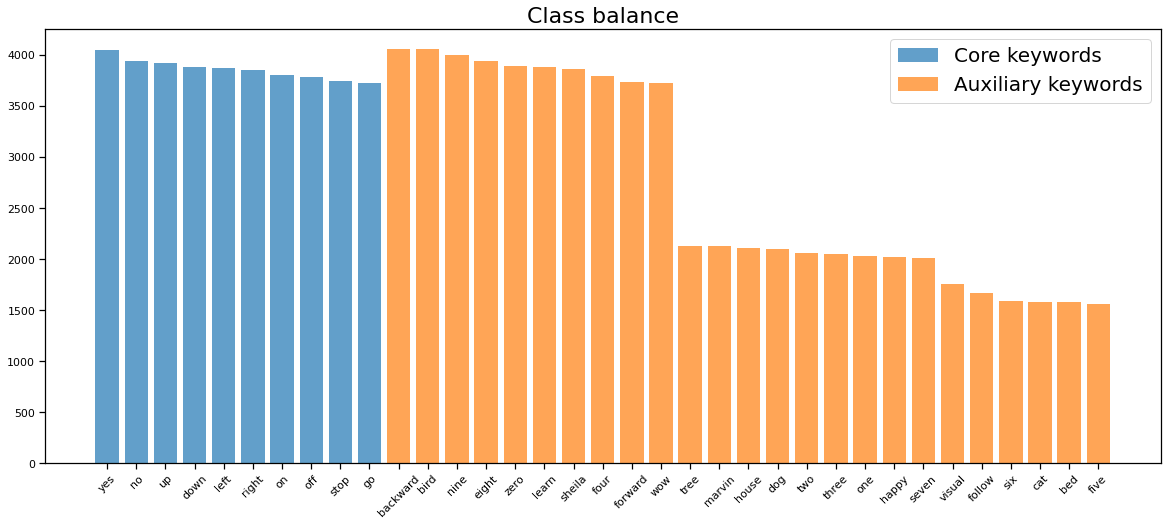

In [3]:
# Let's inspect class balance within the whole dataset
core_samples_amt = []
aux_samples_amt = []
for keyword in core_kws:
    n = len(tf.io.gfile.listdir(_DATA_DIR_/keyword))
#     print(f"Amount of audio files for keyword {keyword}: {n}")
    core_samples_amt.append(n)
    
    
for keyword in aux_kws:
    n = len(tf.io.gfile.listdir(_DATA_DIR_/keyword))
#     print(f"Amount of audio files for keyword {keyword}: {n}")
    aux_samples_amt.append(n)

plt.figure(figsize=(20,8))
plt.bar(core_kws, np.sort(core_samples_amt)[::-1], label="Core keywords", alpha=0.7)
plt.bar(aux_kws, np.sort(aux_samples_amt)[::-1], label="Auxiliary keywords", alpha=0.7)
# plt.bar("filler", sum(np.sort(aux_samples_amt)[::-1]), label="$Filler$ class (all auxiliary combined)", alpha=0.7)
plt.legend(fontsize=20)
plt.xticks(rotation=45)
plt.title("Class balance", fontsize=22)
plt.show()

In [4]:
# ensure they are disjoint sets
print(set(X_train).intersection(set(X_valid)))
print(set(X_valid).intersection(set(X_test)))

{'silence'}
{'silence'}


In [5]:
#dummy datasets

lens = 15
indexes_train = np.random.choice(len(X_train),15)
indexes_valid = np.random.choice(len(X_valid),15)
indexes_test = np.random.choice(len(X_test),15)
X_train = X_train[indexes_train]
y_train = y_train[indexes_train]
X_valid = X_valid[indexes_valid]
y_valid = y_valid[indexes_valid]
X_test = X_test[indexes_test]
y_test = y_test[indexes_test]

In [6]:
train_dataset = create_dataset(X_train, y_train, batch_size=1, is_training=True, cache_file="dummy_train")
valid_dataset = create_dataset(X_valid, y_valid, batch_size=1,cache_file="dummy_valid")
test_dataset = create_dataset(X_test, y_test, batch_size=1, is_test=True, cache_file="dummy_test")

2021-09-06 09:35:01.731441: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-06 09:35:01.786243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-06 09:35:01.786609: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-09-06 09:35:01.786675: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-06 09:35:01.789064: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-06 09:35:01.789171: I tensorflow/stream_executor/platf

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


## Data augmentation, Phase1
In phase 1 the only augmentations are performed at CPU level, and consist in:

 - Random shifts of the Waveforms
 - Random choice for silence samples

2021-09-06 09:35:11.262153: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-06 09:35:11.290027: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2699905000 Hz


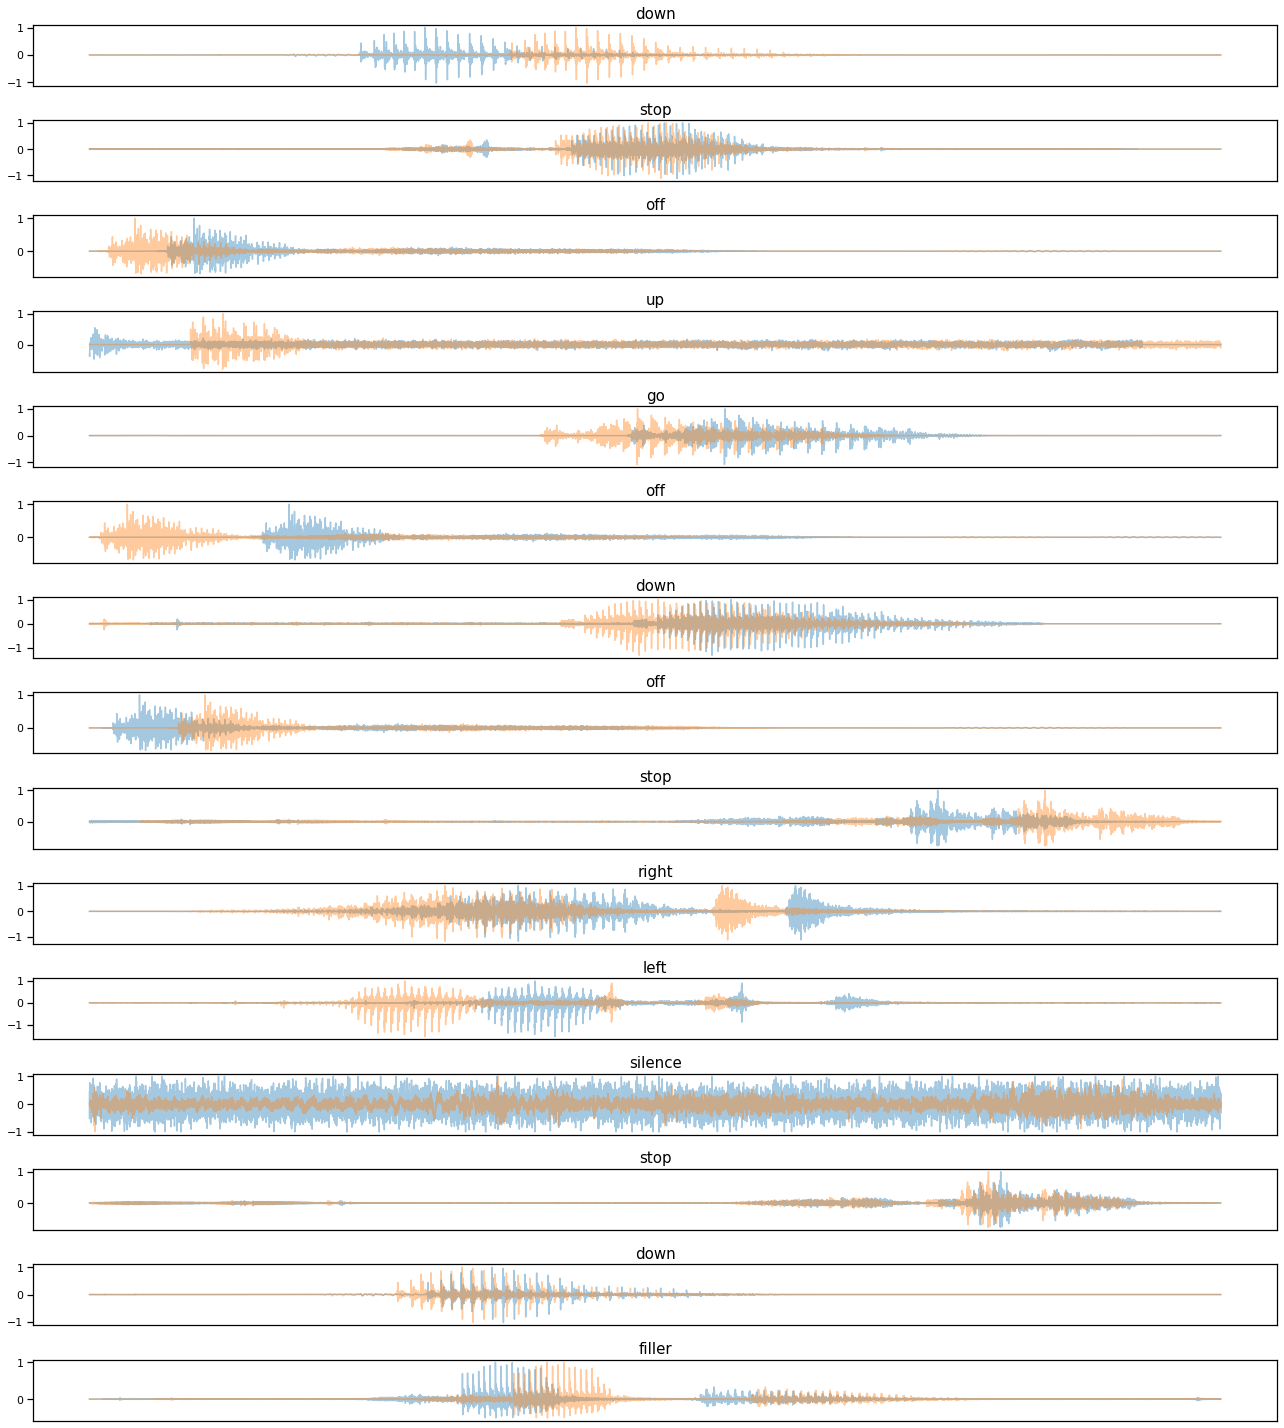

In [7]:
count = 1
plt.figure(figsize=(18,20))

n = lens

for s in train_dataset.take(2*n):
    if count<=n:
#         plt.subplot(20,2,2*count+1)
        plt.subplot(n,1,count)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it1")
        plt.title(output_classes[lab], fontsize=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        plt.subplot(n,1,count-n)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it2")

    count+=1

plt.tight_layout()

plt.show()

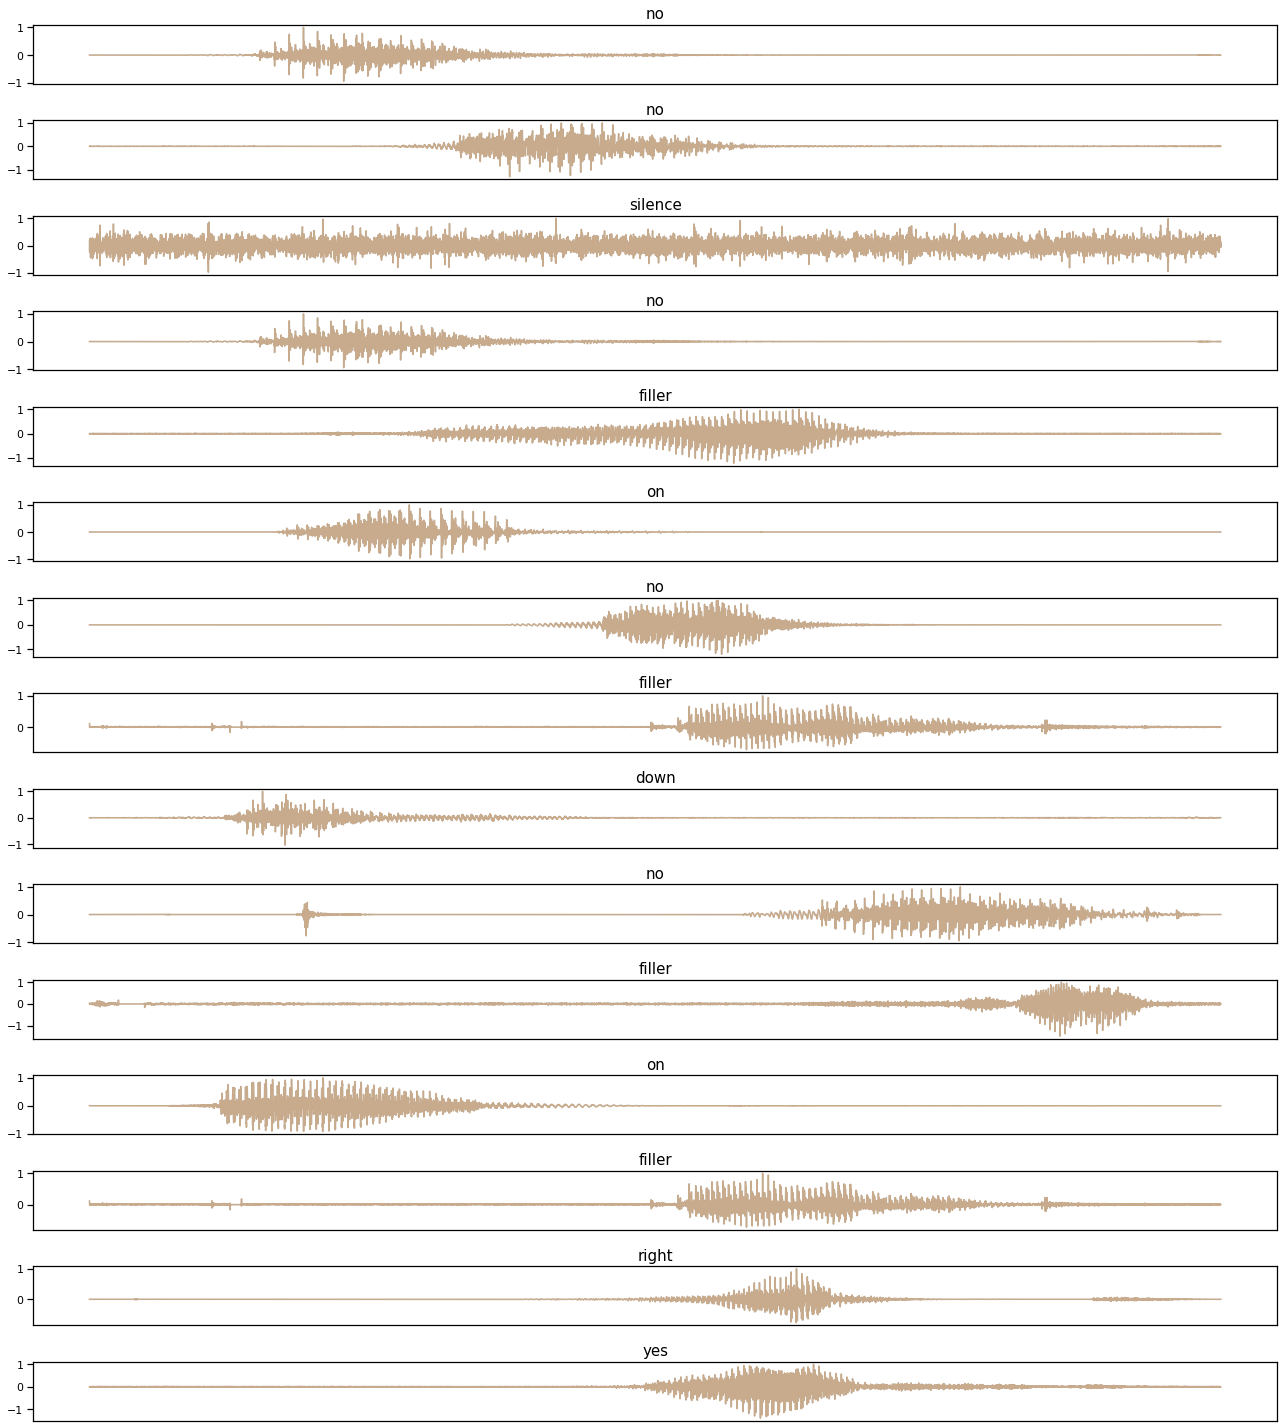

In [8]:
# For the validation set, the augmentation process doesn't take place

count = 1
plt.figure(figsize=(18,20))
for s in valid_dataset.take(2*n):
    if count<=n:
#         plt.subplot(20,2,2*count+1)
        plt.subplot(n,1,count)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it1")
        plt.title(output_classes[lab], fontsize=15)
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
#         plt.subplot(20,2,(count-9)*2)
        plt.subplot(n,1,count-n)
        w = s[0][0]
        lab = s[1][0]
        plt.plot(w, alpha=0.4, label="it2")
#         plt.legend(fontsize=16)
#         plt.title(output_classes[lab])
    count+=1
plt.tight_layout()

plt.show()

## Data Augmentation, Phase 2
### Noise augmentation with the  `RandomNoiseAugment` Layer
This layer takes in input a batch of waveforms, coming from the Phase 1. For each sample, random noise is added with probability 0.8.

In [9]:
aug_layer = RandomNoiseAugment()

In [10]:
ws = []
labs = []
for i in train_dataset.take(10):
    ws.append(i[0])
    labs.append(i[1])
ws = tf.concat(ws, axis=0)
labs = tf.concat(labs, axis=0)

In [11]:
# ws is a batch of 10 examples
ws.shape

TensorShape([10, 16000])

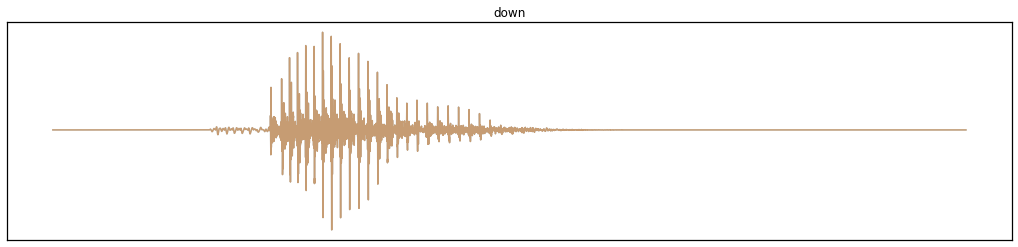

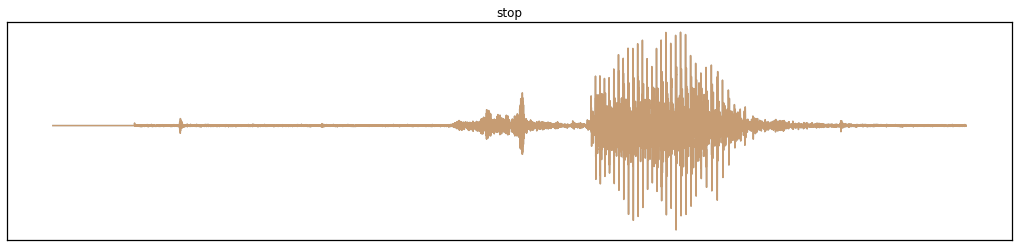

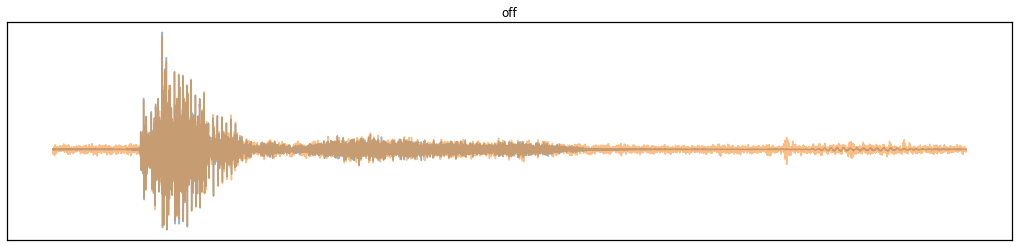

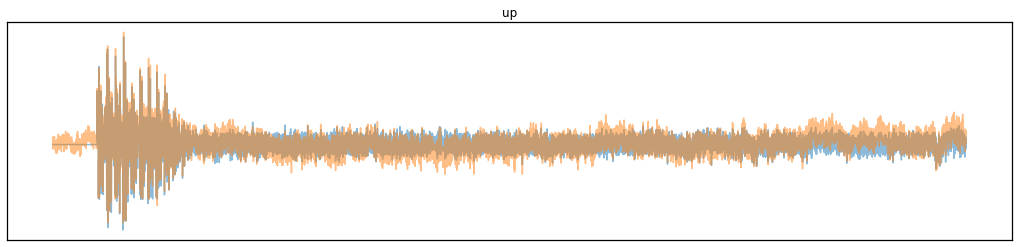

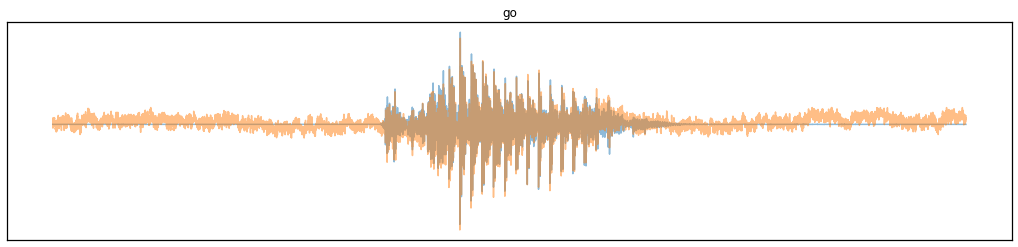

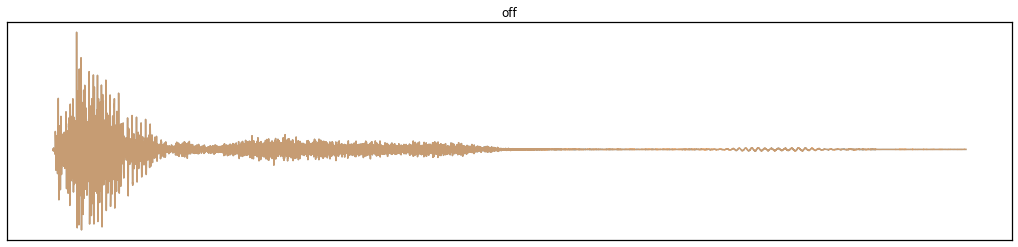

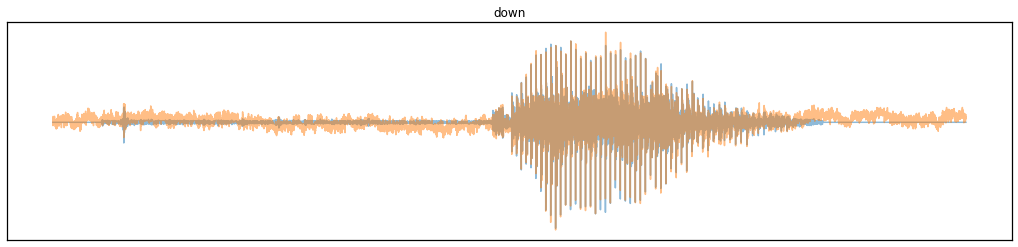

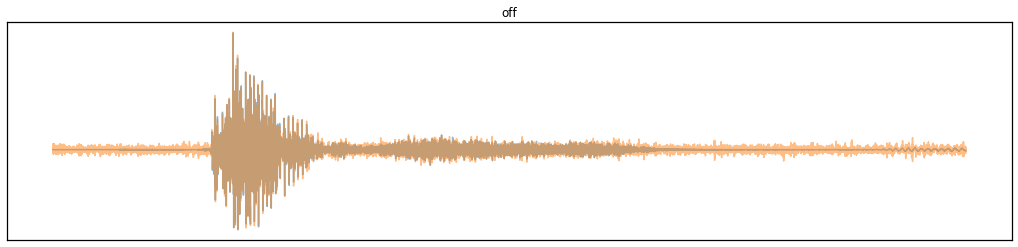

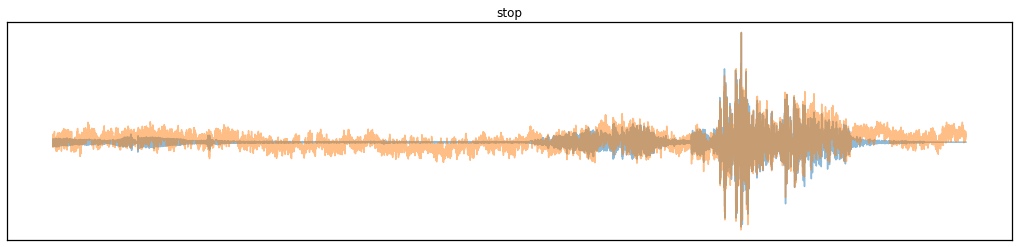

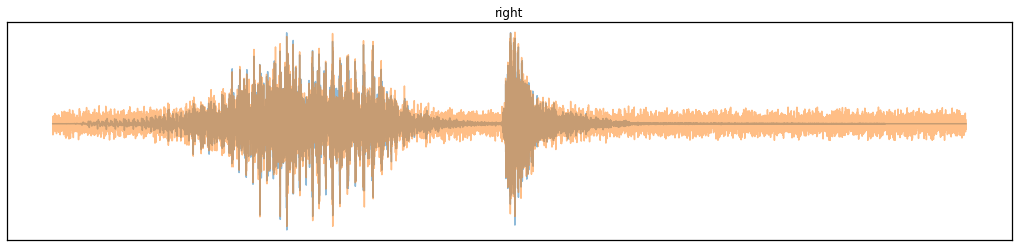

In [13]:
aug_ws = aug_layer(ws, training=True)
sns.set_context("notebook")
# tf.random.set_seed(1234)

# plt.figure(figsize=(20,40))

for i in range(10):
    plt.figure(figsize=(18,4))
    
    plt.plot(ws[i], alpha=0.5)
    plt.title(output_classes[labs[i]])
    plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
#     plt.show()
#     plt.figure(figsize=(18,4))
    plt.plot(aug_ws[i], alpha=0.5)
#     plt.title(output_classes[labs[i]])
    
#     plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
    plt.show()

#     display.display(display.Audio(aug_ws[i],rate=16000))
# plt.savefig("waves.png", dpi=300)


## MFCCS and Spec Augment
### Using the `MFCC` and `SpecAugment` custom layers.
After adding random noise, the waveforms are converted into MFCCs matrices. Then, they undergo the augmentation process from SpecAugment.

### SpecAugment details
from https://arxiv.org/pdf/1904.08779.pdf:

Frequency masking is applied so that $f$ consecutive mel frequency channels $\left[f_{0}, f_{0}+f\right)$ are masked, where $f$ is first chosen from a uniform distribution from 0 to the frequency mask parameter $F$, and $f_{0}$ is chosen from $[0, \nu-f) . \nu$ is the number of mel frequency channels.

Time masking is applied so that $t$ consecutive time steps $\left[t_{0}, t_{0}+t\right)$ are masked, where $t$ is first chosen from a uniform distribution from 0 to the time mask parameter $T$, and $t_{0}$ is chosen from $[0, \tau-t)$.
We introduce an upper bound on the time mask so that a time mask cannot be wider than $p$ times the number of time steps.

In [14]:
mfcc_layer = MFCC()
spec_aug = SpecAugment()
aug_layer = RandomNoiseAugment()

In [15]:
ws.shape

TensorShape([10, 16000])

In [16]:
sns.set_context("poster")
aug_ws = aug_layer(ws, training=True)
X0a = LogMelSpectrogram()(aug_ws)
X0 = LogMelSpectrogram()(ws)
X1 = MFCC(lift_constant=40)(aug_ws)
X02 = spec_aug(X0, training=True)
X2 = spec_aug(X1, training=True)

2021-09-06 09:36:36.528258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-09-06 09:36:36.612230: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


2021-09-06 09:36:36.874374: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


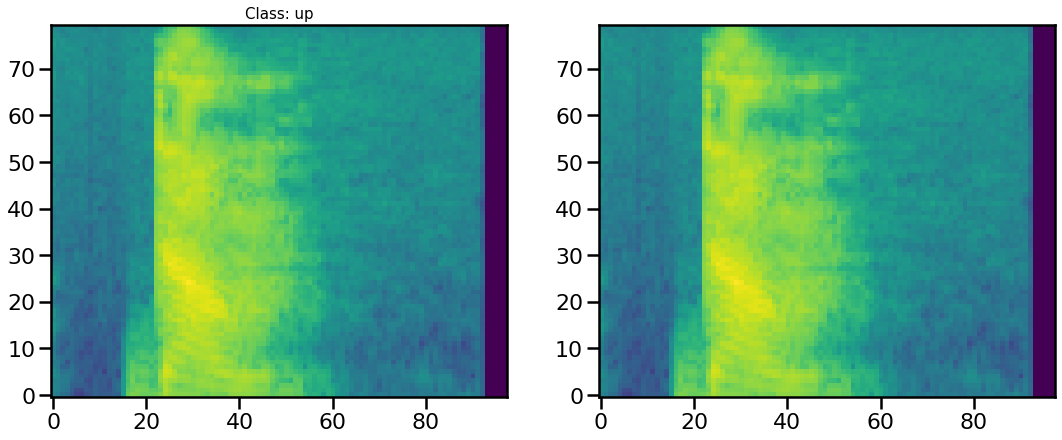

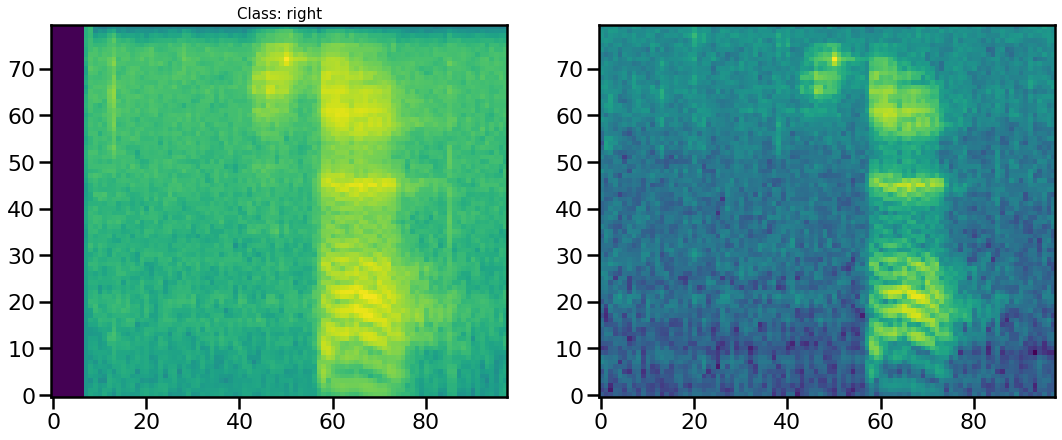

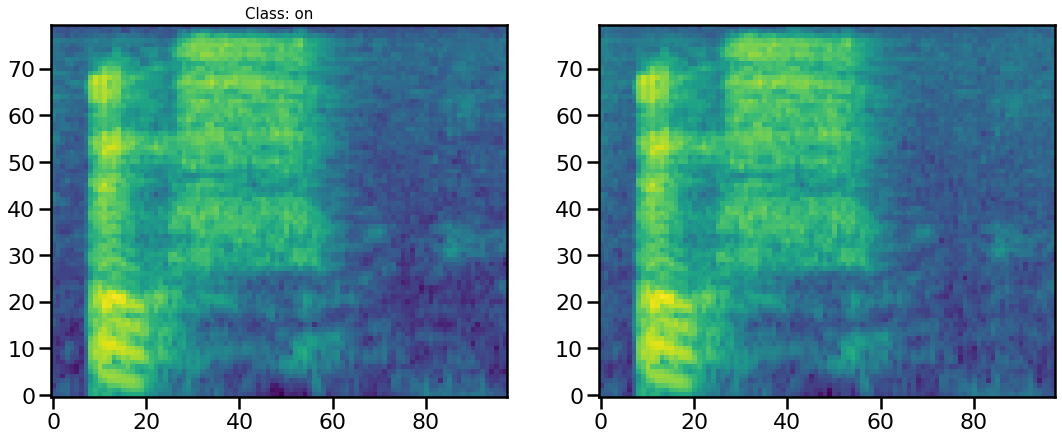

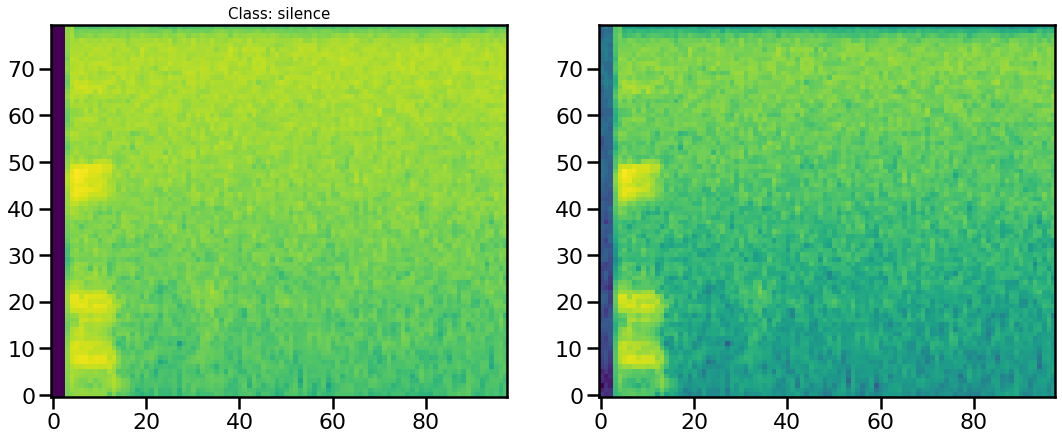

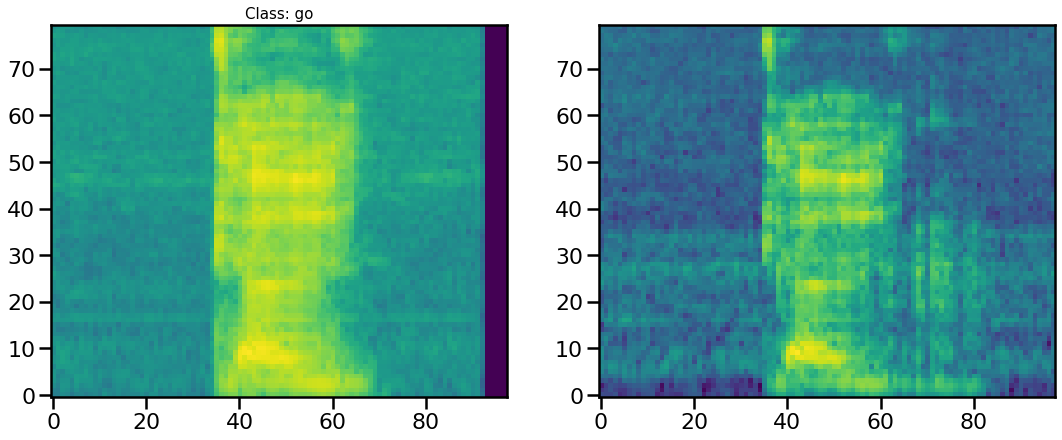

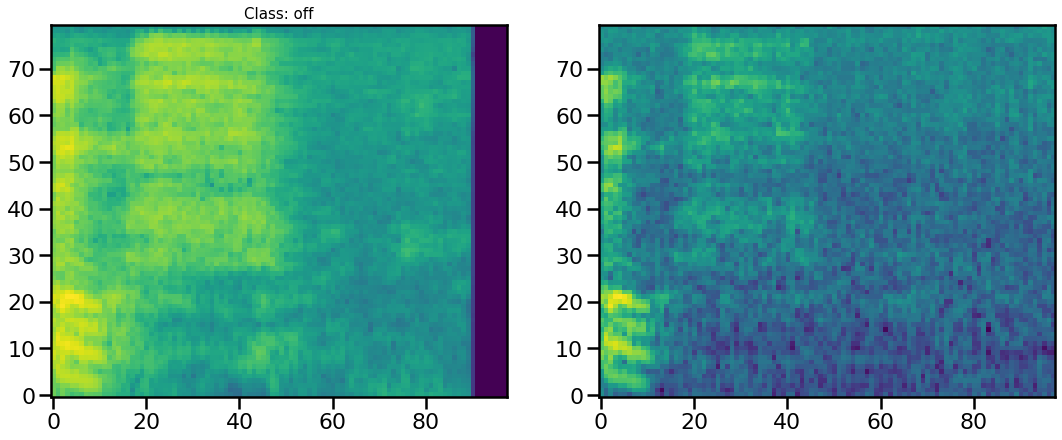

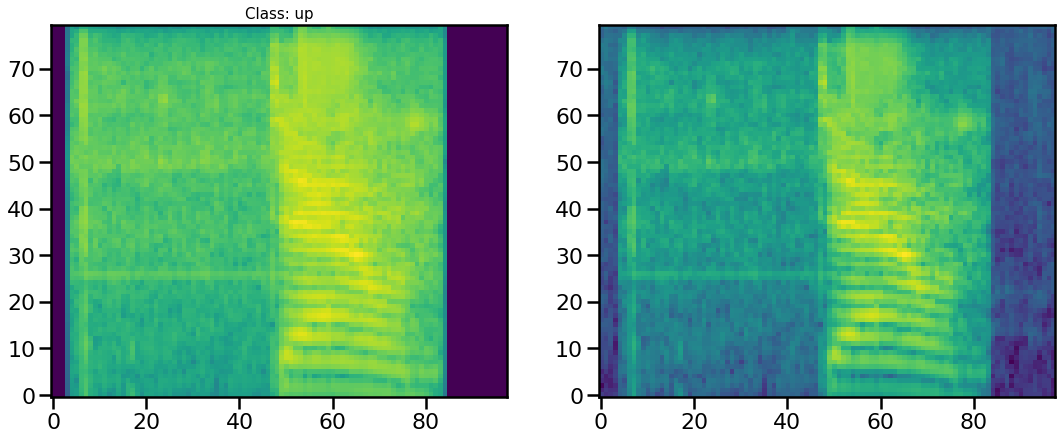

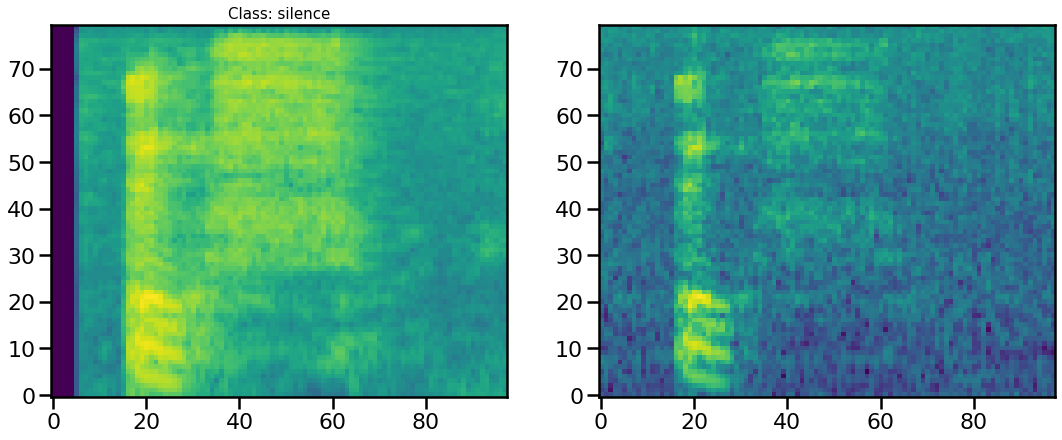

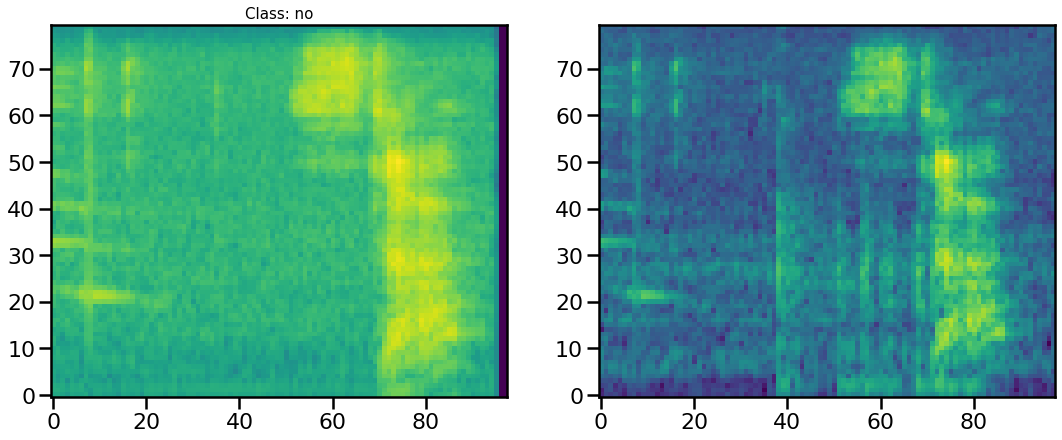

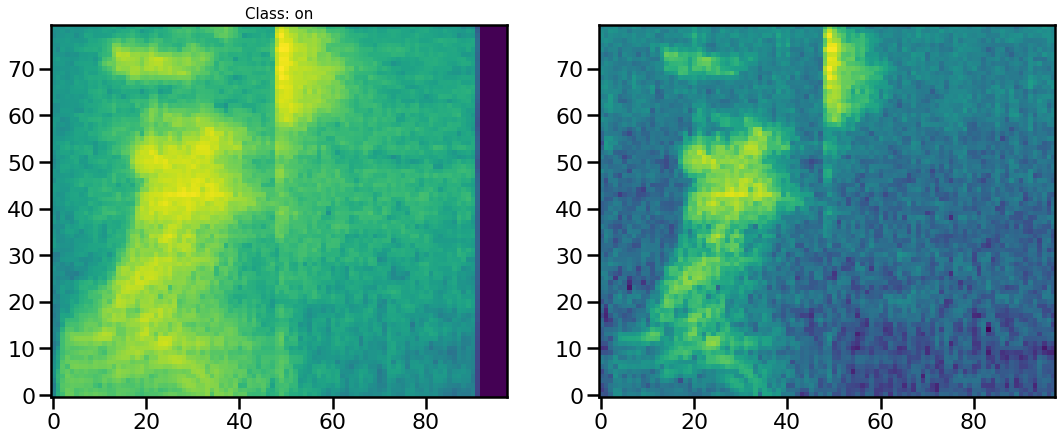

In [17]:
for i in range(10):
    plt.figure(figsize=(18,12))
    plt.subplot(1,2,1)
    plt.imshow(X0[i,:,1:,0].numpy().T, origin='lower')
    plt.title(f"Class: {output_classes[y_train[i]]}", fontsize=15)
    plt.subplot(1,2,2)
    plt.imshow(X0a[i,:,1:,0].numpy().T, origin='lower')
    plt.show()
    display.display(display.Audio(ws[i], rate=16000))
    display.display(display.Audio(aug_ws[i], rate=16000))

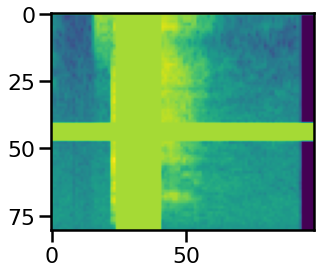

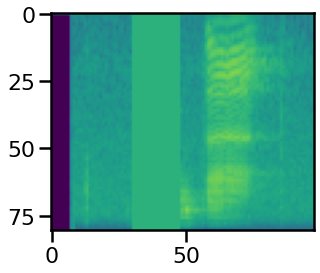

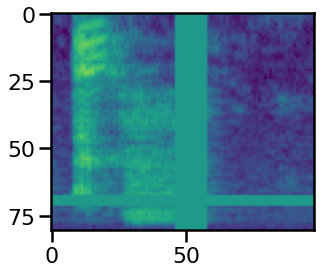

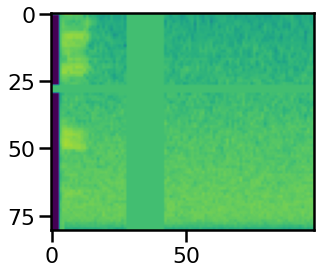

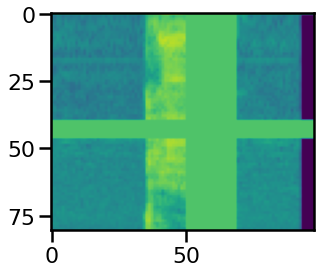

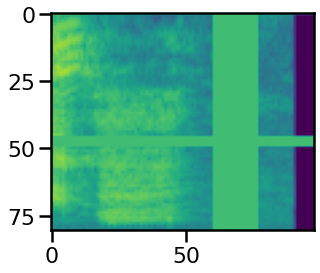

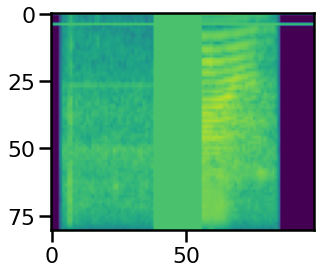

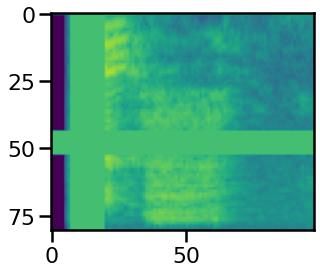

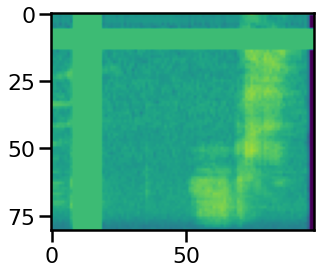

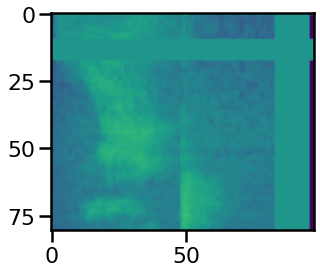

In [18]:
for i in X02:
    plt.imshow(i[:,:,0].numpy().T)
    plt.show()

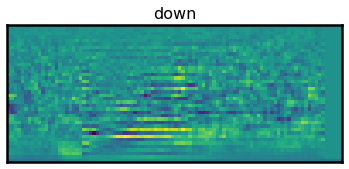

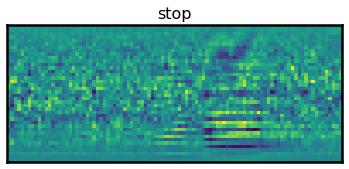

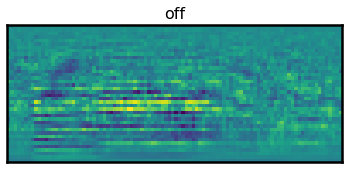

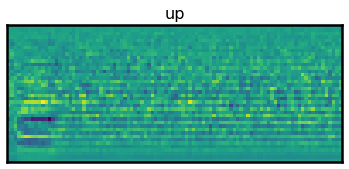

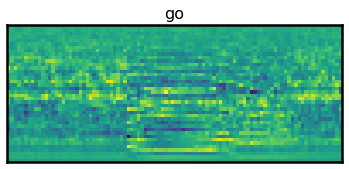

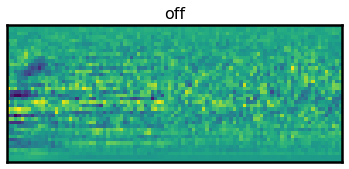

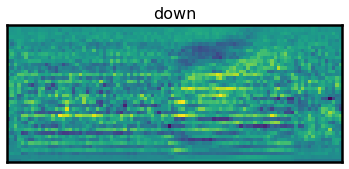

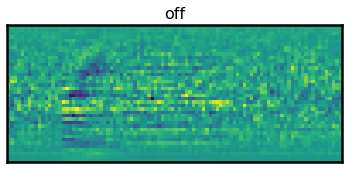

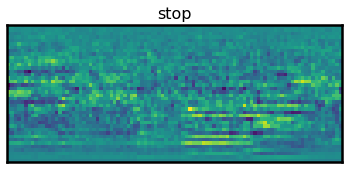

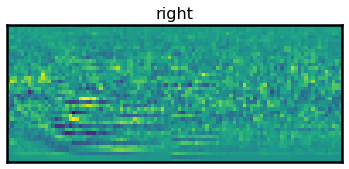

In [19]:
for i in range(10):
    plt.imshow(X1[i,:,:,0].numpy().T, origin='lower')
    plt.title(output_classes[labs[i]], fontsize=16)
    plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    plt.show()

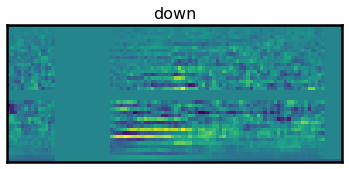

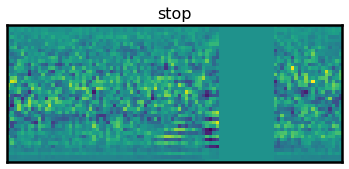

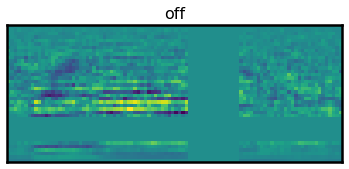

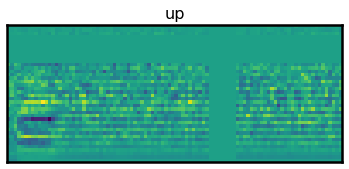

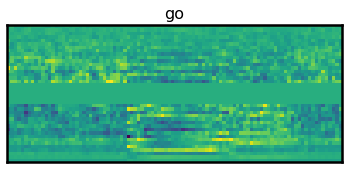

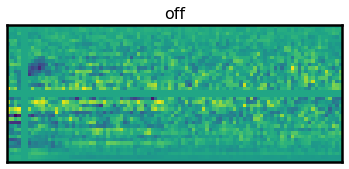

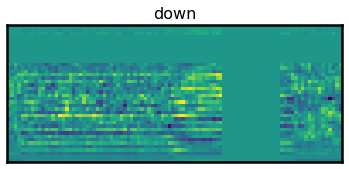

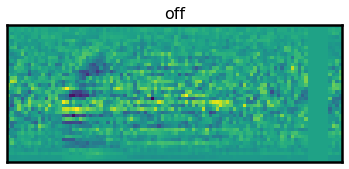

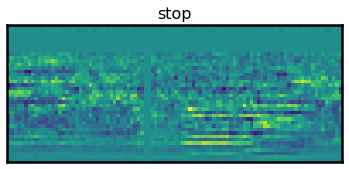

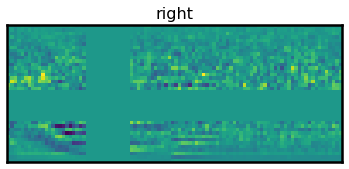

In [20]:
for i in range(10):
    plt.imshow(X2[i,:,:,0].numpy().T, origin='lower')
    plt.title(output_classes[labs[i]], fontsize=16)
    plt.tick_params(left = False, right = False , labelleft = False ,
            labelbottom = False, bottom = False)
    plt.show()